# Importation des bibliothèques

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from datetime import datetime

# Facebook Prophet
!pip install fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet import hdays
!pip install holidays
import holidays

# Importation et visualisation des données

In [34]:
# Si vous utilisez Colab

# !mkdir Data
# !wget --no-check-certificate -r "https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv" -O "Data/RetailSales.csv"

mkdir: cannot create directory ‘Data’: File exists
will be placed in the single file you specified.

--2020-06-30 07:40:35--  https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5279 (5.2K) [text/plain]
Saving to: ‘Data/RetailSales.csv’

Data/RetailSales.cs 100%[===================>]   5.16K  --.-KB/s    in 0s      

2020-06-30 07:40:35 (54.4 MB/s) - ‘Data/RetailSales.csv’ saved [5279/5279]

FINISHED --2020-06-30 07:40:35--
Total wall clock time: 0.07s
Downloaded: 1 files, 5.2K in 0s (54.4 MB/s)


In [35]:
RetailSalesDataframe = pd.read_csv("./Data/RetailSales.csv", delimiter=",")
RetailSalesDataframe["ds"] = pd.to_datetime(RetailSalesDataframe["ds"], infer_datetime_format=True)
RetailSalesDataframe["y"] = pd.to_numeric(RetailSalesDataframe["y"])
indexedDataframe = RetailSalesDataframe.set_index(["ds"])

In [36]:
print("--- Head and tail of dataframe ---\n")

print(RetailSalesDataframe.head(5))
print(RetailSalesDataframe.tail(5))

print("\n--- Dataframe infos ---\n")

RetailSalesDataframe.info()

--- Head and tail of dataframe ---

          ds       y
0 1992-01-01  146376
1 1992-02-01  147079
2 1992-03-01  159336
3 1992-04-01  163669
4 1992-05-01  170068
            ds       y
288 2016-01-01  400928
289 2016-02-01  413554
290 2016-03-01  460093
291 2016-04-01  450935
292 2016-05-01  471421

--- Dataframe infos ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      293 non-null    datetime64[ns]
 1   y       293 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.7 KB


In [37]:
Roolmean = indexedDataframe.rolling(window = 12).mean()
Roolstd = indexedDataframe.rolling(window = 12).std()
print(Roolmean, Roolstd)

                        y
ds                       
1992-01-01            NaN
1992-02-01            NaN
1992-03-01            NaN
1992-04-01            NaN
1992-05-01            NaN
...                   ...
2016-01-01  444476.666667
2016-02-01  446694.916667
2016-03-01  448026.833333
2016-04-01  449086.666667
2016-05-01  449820.500000

[293 rows x 1 columns]                        y
ds                      
1992-01-01           NaN
1992-02-01           NaN
1992-03-01           NaN
1992-04-01           NaN
1992-05-01           NaN
...                  ...
2016-01-01  32379.612074
2016-02-01  28792.284909
2016-03-01  29030.534382
2016-04-01  28871.560141
2016-05-01  29354.543308

[293 rows x 1 columns]


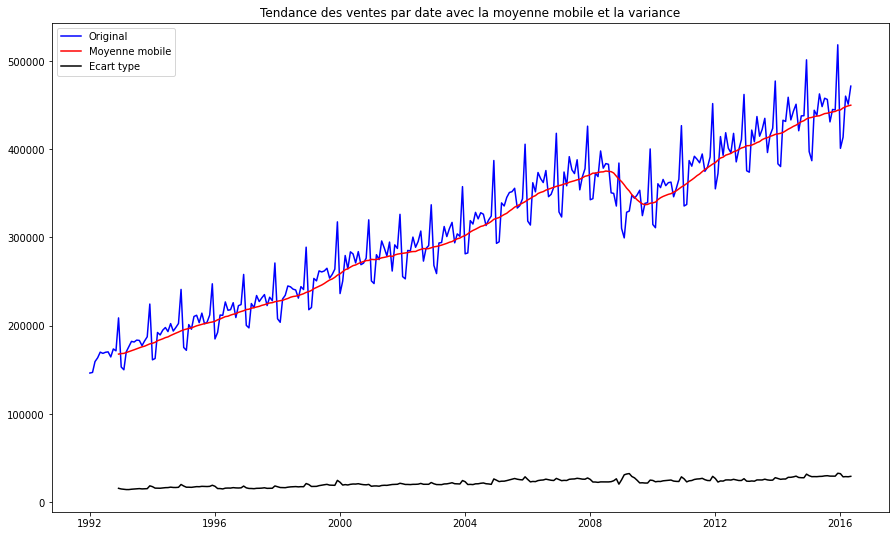

In [38]:
orig = plt.plot(indexedDataframe, color = "blue", label = "Original")
mean = plt.plot(Roolmean, color = "red", label = "Moyenne mobile")
std = plt.plot(Roolstd, color = "black", label = "Ecart type")
plt.legend(loc = "best")
plt.title("Tendance des ventes par date avec la moyenne mobile et la variance")
plt.rcParams["figure.figsize"] = [15,9]
plt.show(block = False)

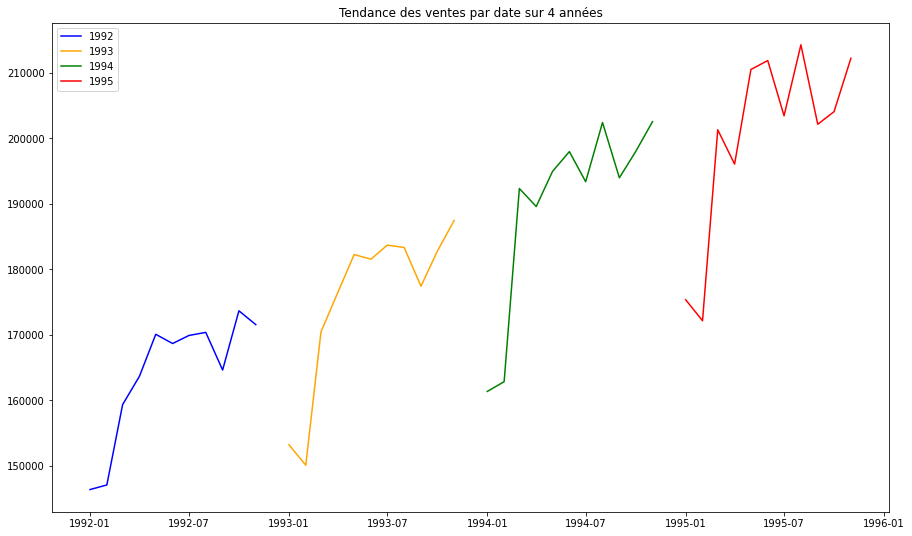

In [39]:
ye1 = plt.plot(indexedDataframe[0:11], color = "blue", label = "1992")
ye2 = plt.plot(indexedDataframe[12:23], color = "orange", label = "1993")
ye3 = plt.plot(indexedDataframe[24:35], color = "green", label = "1994")
ye4 = plt.plot(indexedDataframe[36:47], color = "red", label = "1995")
plt.legend(loc = "best")
plt.title("Tendance des ventes par date sur 4 années")
plt.show(block = False)

Courbe dont l'alure est non stationnaire et suit une tendence saisonière avec peu de ventes sur les 1ers mois de l'année. Les ventes augmentent de façon significtives pendant l'été et retombent après le mois d'aout et reprennent pendant la periode de noel.





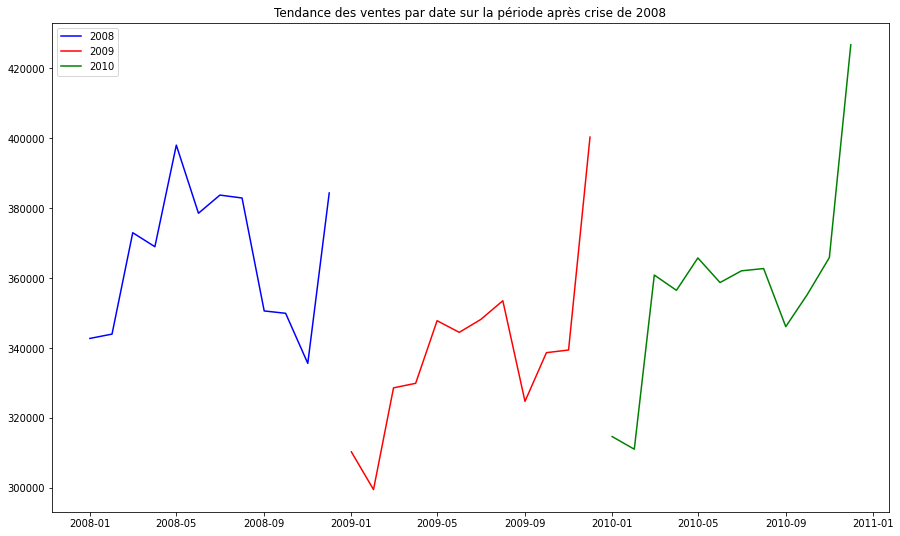

In [40]:
crisis08 = plt.plot(indexedDataframe.loc['2008-01-01':'2008-12-30'], color = "blue", label = "2008")
crisis09 = plt.plot(indexedDataframe.loc['2009-01-01':'2009-12-30'], color = "red", label = "2009")
crisis09 = plt.plot(indexedDataframe.loc['2010-01-01':'2010-12-30'], color = "green", label = "2010")
plt.legend(loc = "best")
plt.title("Tendance des ventes par date sur la période après crise de 2008")
plt.show(block = False)

Le graphe précedent relate l'impact de la crise financiere de 2008 sur le nombre de ventes. En effet, les ventes ont baissé durant l'année 2009 pour reprendre la tendance positive progressive à partir de 2010.

# Creation du modèle Prophet

In [41]:
prophetModel = Prophet(seasonality_mode='multiplicative')

In [42]:
 prophetModel = prophetModel.fit(RetailSalesDataframe)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
future = prophetModel.make_future_dataframe(periods=60, freq='M')

In [44]:
forecast = prophetModel.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
348,2020-12-31,477968.216456,448178.939481,510666.669221
349,2021-01-31,491391.790216,460372.950047,523736.116473
350,2021-02-28,534643.648481,499696.971092,571100.355885
351,2021-03-31,533626.598859,497942.733514,572427.228000
352,2021-04-30,564182.983446,526215.569136,604957.286337


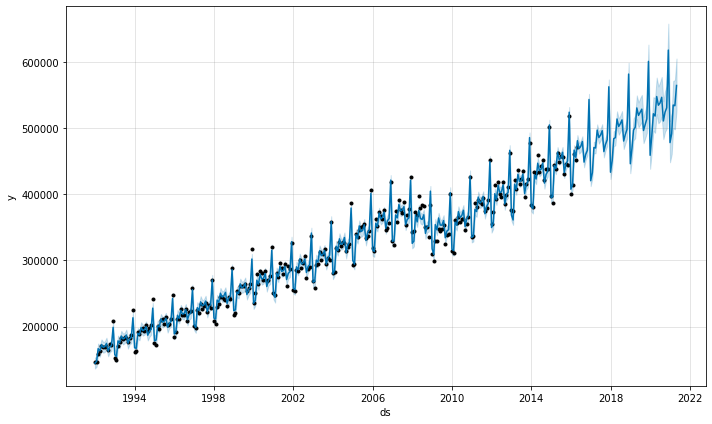

In [45]:
fig1 = prophetModel.plot(forecast)

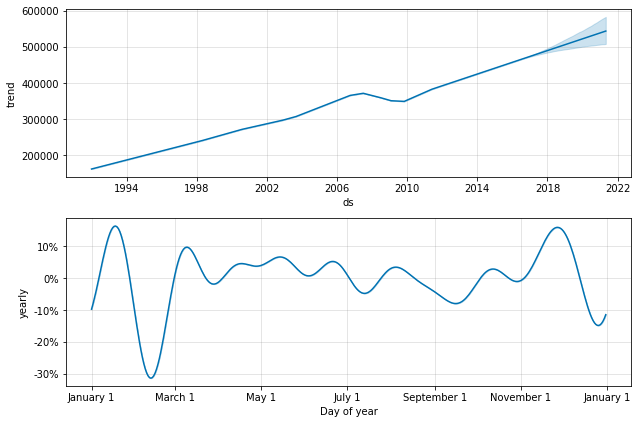

In [46]:
fig2 = prophetModel.plot_components(forecast)

# Evaluation du modèle

In [47]:
df_cv = cross_validation(prophetModel, initial = '7665 days', period = '30 days', horizon = '180 days')
df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 35 forecasts with cutoffs between 2013-01-17 00:00:00 and 2015-11-03 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,22 days,7.118432e+07,8437.080081,5852.077363,0.014019,0.009303,0.714286
1,23 days,6.815212e+07,8255.429688,5626.364782,0.013249,0.008103,0.761905
2,24 days,4.254871e+07,6522.937545,5014.582443,0.011342,0.008533,0.809524
3,25 days,5.739570e+07,7575.994804,5912.212794,0.013452,0.009697,0.761905
4,26 days,6.345495e+07,7965.861781,6316.968375,0.014359,0.009836,0.730159
...,...,...,...,...,...,...,...
85,176 days,7.355889e+07,8576.647852,7002.177943,0.015960,0.012751,0.634921
86,177 days,7.143554e+07,8451.954993,7018.960683,0.016070,0.012990,0.666667
87,178 days,8.684374e+07,9318.998677,7955.099784,0.017943,0.016235,0.571429
88,179 days,1.001935e+08,10009.669567,8787.564789,0.019883,0.019183,0.492063


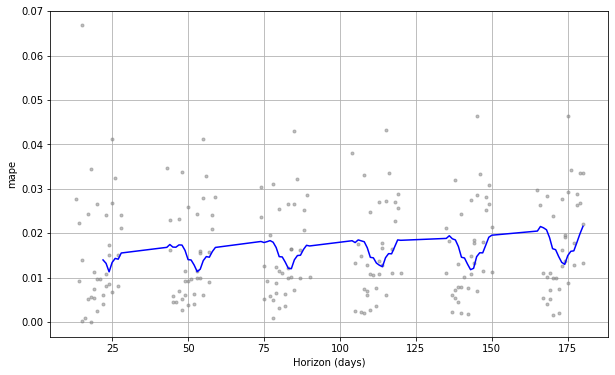

In [48]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

# BONUS : Integration des jours fériés, vacances et événements speciaux de l'année

La bibliothèque de Prophet propose deja une integration des jours spéciaux sur plusieurs pays et qui sont :
Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Turkey (TU), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU) accessibles à travers hdays.nomPays_ou_codeISO qui est la classe qui donne accès à plusieurs methodes de generation de jours spéciaux pour ces pays




In [49]:
russiaHdays = hdays.Russia()

In [50]:
russiaHdays._populate(2020)
russiaHdays

{datetime.date(2020, 1, 1): "New Year's Day",
 datetime.date(2020, 1, 7): 'Orthodox Christmas Day',
 datetime.date(2020, 2, 23): 'Defender of the Fatherland Day',
 datetime.date(2020, 3, 8): "International Women's Day",
 datetime.date(2020, 5, 1): 'Spring and Labour Day',
 datetime.date(2020, 5, 9): 'Victory Day',
 datetime.date(2020, 6, 12): 'Russia Day',
 datetime.date(2020, 8, 22): 'National Flag Day',
 datetime.date(2020, 11, 4): 'Unity Day',
 datetime.date(2020, 12, 25): 'Christmas Day'}

Si ces pays ne correspondent pas à vos attentes, une biliothèque disponible sur le lien suivant propose plusieurs pays dont les Etats Unis, la France ... Et comme notre heu de données correspond à des ventes en US, il faudrai integrer ces jours spéciaux des Etats Unis. 

In [51]:
print(holidays.list_supported_countries())

['AR', 'AT', 'AU', 'AW', 'Argentina', 'Aruba', 'Australia', 'Austria', 'BE', 'BG', 'BR', 'BY', 'Belarus', 'Belgium', 'Brazil', 'Bulgaria', 'CA', 'CH', 'CL', 'CO', 'CZ', 'Canada', 'Chile', 'Colombia', 'Croatia', 'Czech', 'Czechia', 'DE', 'DK', 'DO', 'Denmark', 'DominicanRepublic', 'ECB', 'EE', 'ES', 'England', 'Estonia', 'EuropeanCentralBank', 'FI', 'FRA', 'Finland', 'France', 'GB', 'Germany', 'HK', 'HND', 'HR', 'HU', 'HolidayBase', 'Honduras', 'HongKong', 'Hungary', 'IE', 'IND', 'IS', 'IT', 'Iceland', 'India', 'Ireland', 'IsleOfMan', 'Italy', 'JP', 'Japan', 'KE', 'Kenya', 'LT', 'LU', 'Lithuania', 'Luxembourg', 'MX', 'Mexico', 'NG', 'NI', 'NL', 'NO', 'NZ', 'Netherlands', 'NewZealand', 'Nicaragua', 'Nigeria', 'NorthernIreland', 'Norway', 'PE', 'PL', 'PT', 'PTE', 'Peru', 'Poland', 'Polish', 'Portugal', 'PortugalExt', 'RU', 'Russia', 'SE', 'SI', 'SK', 'Scotland', 'Slovak', 'Slovakia', 'Slovenia', 'SouthAfrica', 'Spain', 'Sweden', 'Switzerland', 'TAR', 'UA', 'UK', 'US', 'Ukraine', 'UnitedKi

In [52]:
usaHdays = holidays.UnitedStates()

In [53]:
usaHdays._populate(2020)
usaHdays

{datetime.date(2020, 1, 1): "New Year's Day",
 datetime.date(2020, 1, 20): 'Martin Luther King, Jr. Day',
 datetime.date(2020, 2, 17): "Washington's Birthday",
 datetime.date(2020, 5, 25): 'Memorial Day',
 datetime.date(2020, 7, 3): 'Independence Day (Observed)',
 datetime.date(2020, 7, 4): 'Independence Day',
 datetime.date(2020, 9, 7): 'Labor Day',
 datetime.date(2020, 10, 12): 'Columbus Day',
 datetime.date(2020, 11, 11): 'Veterans Day',
 datetime.date(2020, 11, 26): 'Thanksgiving',
 datetime.date(2020, 12, 25): 'Christmas Day'}

In [54]:
tmpUsaHdays = holidays.UnitedStates()
for y in range(1992,2016):
  tmpUsaHdays._populate(y)

In [55]:
holidaysDataframe = pd.DataFrame.from_dict(tmpUsaHdays, orient='index')
holidaysDataframe = holidaysDataframe.reset_index()
holidaysDataframe.columns = ["ds", "holiday"]

Pour les integrer, rien de plus simple:

In [56]:
prophetModel = Prophet(holidays = holidaysDataframe, seasonality_mode='multiplicative')